# Projet SDATA

## Exercice 1

### Analyse des données 

La première étape est d'analyser les données contenues dans les fichiers ***spotify_dataset_train.csv*** et ***spotify_dataset_test.csv***. 
Avant de commencer, il nous faut formatter les données afin qu'elles soient numériques. Cela permettra ensuite d'utiliser certaines métriques comme les matrices de confusion par exemple.

Dans le code ci-dessous, nous chargeons donc les données d'entraînement et de test dans `dataset_train` et `dataset_test` respectivement.

Ensuite, le première variable à formatter est la variable ***explicit*** qui est, par défaut, représentée par des booléens. On transforme alors les booléens en 0 et 1 pour obtenir une valeur numérique.

La deuxième variable que nous devons modifier est la ***release_date***. Celle-ci est représentée par un `datetime` qui est un format de représentation des dates. Nous voulons obtenir un `timestamp` représentant la date sous la forme d'un nombre. 
Nous repérons plusieurs problèmes:
* Les données ne sont pas toutes au même format: par exemple: `2015-11-06` ou `1997`
* Certaines musiques sont sortis avant le 1er janvier 1970, référence du temps Unix

Pour résoudre ce problème, nous parcourons les ***release_dates***, on détecte le format, puis on le remplace par un `timestamp` en utilisant la time zone 'UTC' (Coordinated Universal Time) permettant d'éviter les soucis avant pour les dates avant 1970. Afin d'éviter les problèmes, nous affichons les valeurs que nous avons pas réussi à transformer correctement afin de pouvoir adapter le code si nécessaire.

Enfin, nous profitons de la boucle *for* pour remplacer le nom des genres en l'index associé dans la liste des genres, permettant ainsi d'obtenir un dataset complet ne contenant que des valeurs numériques.

In [1]:
import datetime

import numpy as np
import pandas

dataset_train = pandas.read_csv("dataset/spotify_dataset_train.csv")
dataset_test = pandas.read_csv("dataset/spotify_dataset_test.csv")

GENRE_MAP = ['blues', 'chanson', 'classical', 'country', 'dance', 'disco', 'edm', 'electro', 'folk', 'hip hop', 'jazz',
             'latin', 'metal', 'pop', 'punk', 'r&b', 'rap', 'reggae', 'rock', 'salsa', 'soul', 'techno']

dataset_train['explicit'] = dataset_train['explicit'].astype(np.int8)
dataset_test['explicit'] = dataset_test['explicit'].astype(np.int8)

for i, date in enumerate(dataset_train['release_date']):
    # Detect the date format and replace it with a utc timestamp for the train dataset
    if len(date.split('-')) == 3:
        dataset_train.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y-%m-%d").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    elif len(date.split('-')) == 2:
        dataset_train.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y-%m").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    elif len(date.split('-')) == 1:
        dataset_train.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    else:
        print(date)

    # Transform the genre string by the index equivalent
    dataset_train.loc[i, 'genre'] = GENRE_MAP.index(dataset_train.loc[i, 'genre'])

for i, date in enumerate(dataset_test['release_date']):
    # Detect the date format and replace it with a utc timestamp for the test dataset
    if len(date.split('-')) == 3:
        dataset_test.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y-%m-%d").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    elif len(date.split('-')) == 2:
        dataset_test.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y-%m").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    elif len(date.split('-')) == 1:
        dataset_test.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    else:
        print(date)

Il est maintenant temps de visualiser les données et de les comparer. 

La première chose que nous faisons est une matrice des corrélations, en utilisant `seaborn` et `matplotlib` pour les affichages.
On remarque grâce à cette matrice que peu de données sont réellement corrélées. Les seules choses que nous pouvons relever sont:
* ***loudness*** positivement corrélée avec ***energy***
* ***speechiness*** est positivement corrélée avec ***explicit***
* ***accousticness*** est négativement corrélée avec ***loudness*** et ***energy***

Ces corrélations sont tout à fait naturelles et semblent cohérentes avec le sujet. Par exemple, il n'est pas surprenant que les musiques contenant beaucoup de paroles aient une plus grande probabilité d'être explicites, ou encore il n'est pas surpenant que les musiques accoustiques soient peu énergiques.

La deuxième visualisation que nous faisons est un simple diagramme en barres des différentes classes représentées. Cela nous montre une chose intéressante: les différents genres ne contiennent pas du tout la même quantité de données, ce qui signifie, au vu des résultats, que les données choisies sont principalement basées sur la popularité des différents genres plutôt que dans l'objectif de faire un apprentissage équivalent sur chaque genre.

À l'aide de ces rapides analyses, nous supposons qu'il ne sera pas évident de prédire les classes car, premièrement, au vu de la matrice des corrélations, le genre n'est corrélé avec aucune autre variable, de plus, comme certains genres ne sont pas très présent, il y aura peu de données pour entraîner notre modèle.

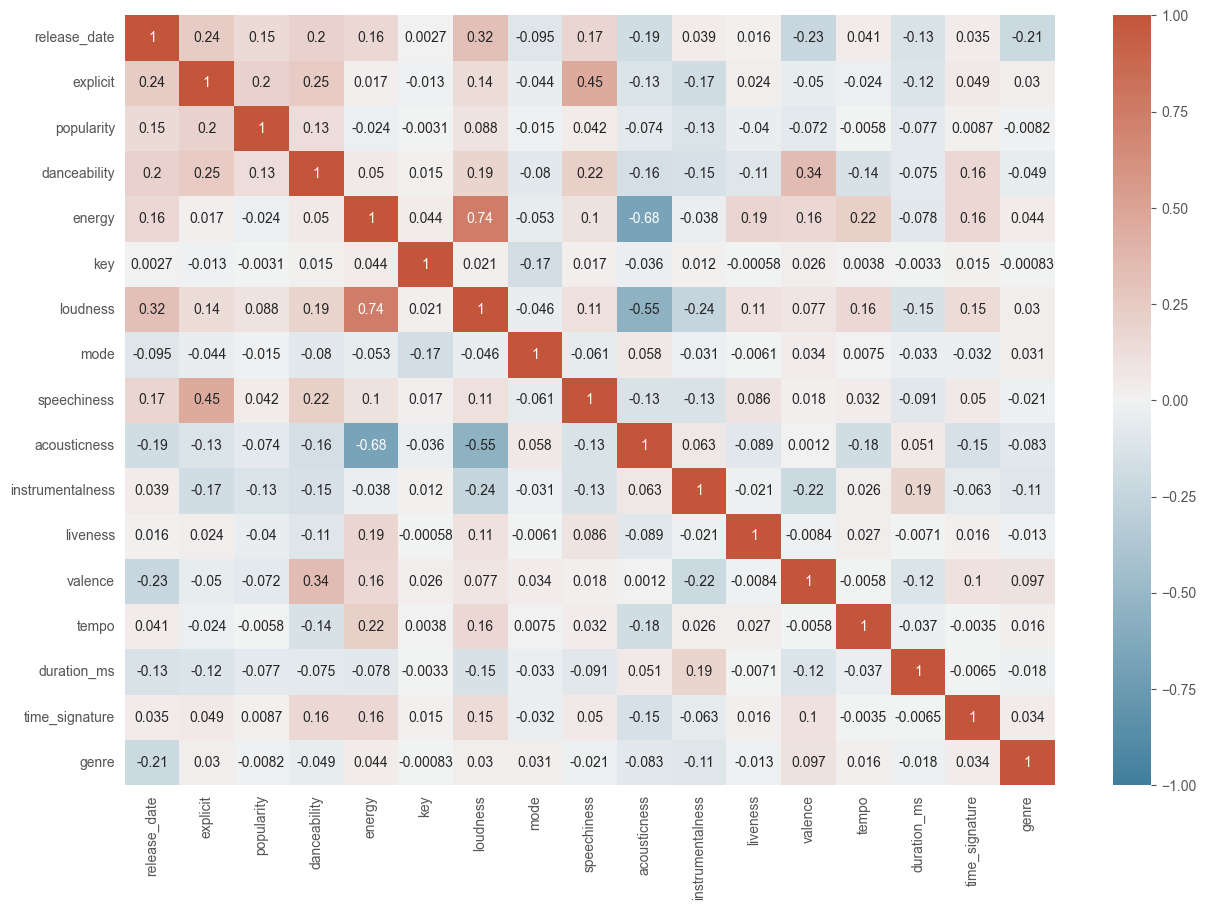

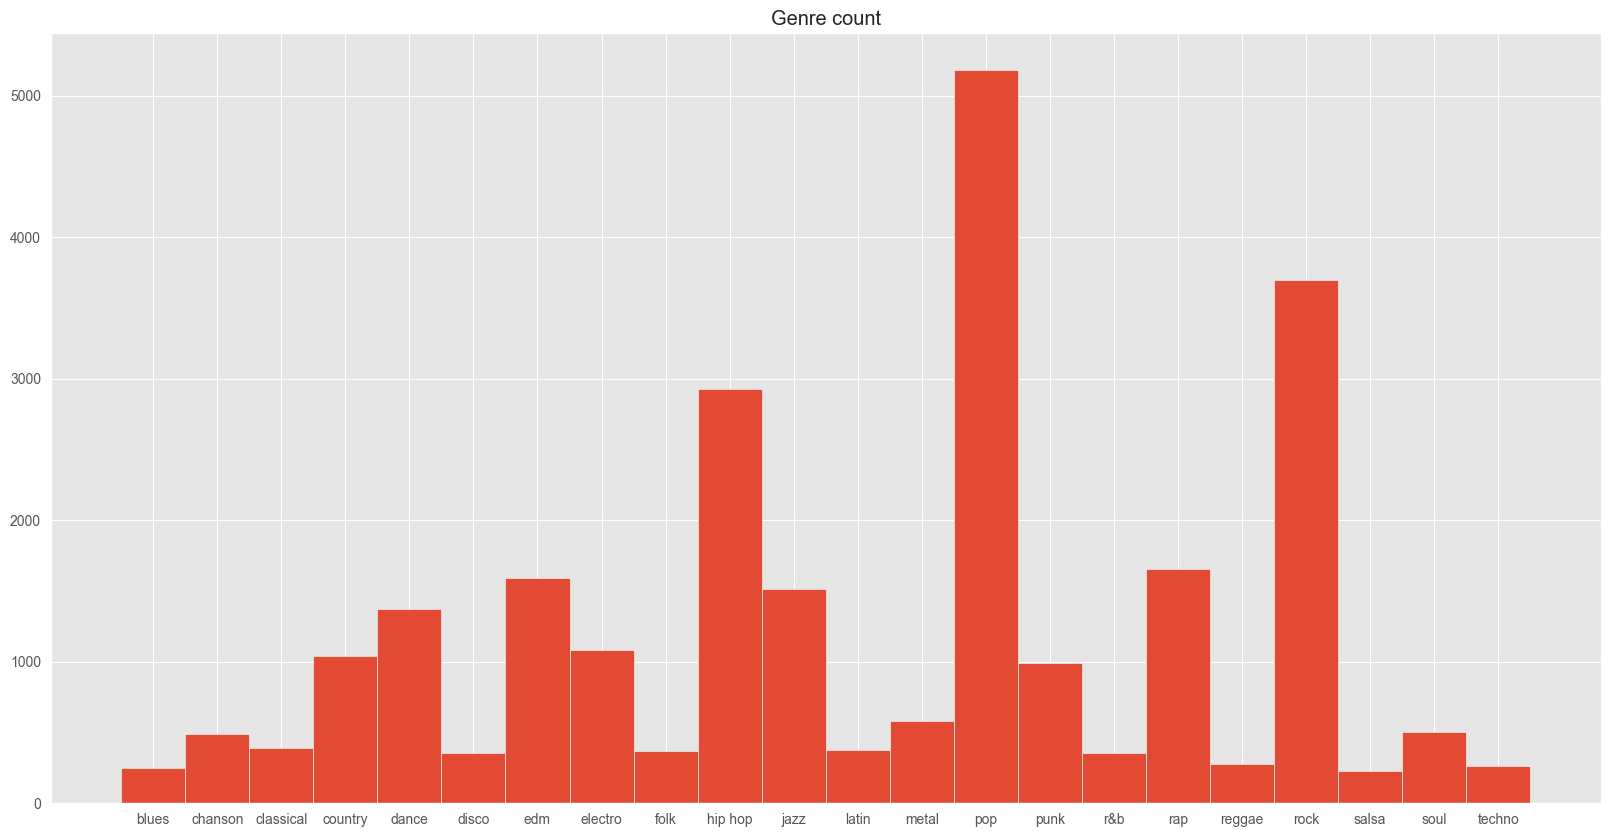

In [242]:
from matplotlib import pyplot as plt
import seaborn

plt.style.use('ggplot')
%matplotlib inline


# Correlation
corr = dataset_train.corr()
plt.figure(figsize=(15, 10))
seaborn.heatmap(corr,
                cmap=seaborn.diverging_palette(230, 20, as_cmap=True),
                vmin=-1.0, vmax=1.0,
                square=False, annot=True)

# Genre count
plt.figure(figsize=(20, 10))
genre_counts = [np.count_nonzero(dataset_train['genre'] == x) for x in range(len(GENRE_MAP))]
classes_weight = {}
for i in range(len(GENRE_MAP)):
    classes_weight[i] = genre_counts[i]
plt.bar(GENRE_MAP, genre_counts, width=1, align='center')
plt.title('Genre count')

plt.show()

Nous décidons ensuite d'ajouter une couche d'analyse plus spécifique. Nous avons 2 types de variables: 
* Les variables allant d'un minimum à un maximum: exemple ***loudness***, plus elle est grande plus la musique est forte
* Les variables représentant une caractéristiques: exemple ***key*** représentant la note principale du morceau

Nous faisons donc une analyse pour ces deux catégories afin de découvrir quels genres se cachent derrière les différentes variables. 

Dans ce premier programme, nous gardons les paramètres du type min-max qui sont intéressants et comparons les moyennes sur chaque genre. La seule variable qui n'est pas du type min-max que nous utilisons malgré tout est la variable ***explicit***, cependant, contrainement à un paramètre comme ***mode*** qui vaut 0 pour majeur et 1 pour mineur, il est intéressant de faire une moyenne du paramètre ***explicit*** (valant 0 pour du contenu non explicite et 1 sinon) puisqu'il nous donnera un pourcentage de musiques contenant du contenu explicite au sein d'un genre.

Pour ce faire, nous utilisons `numpy.mean` qui permet de faire la moyenne sur chaque variable, le tout en construisant une sous-liste ne contenant que les données d'un genre donné à l'aide de `numpy.where`. Cela nous crée donc, pour chaque genre, une liste de taille *nombre_de_variables_intéressantes* contenant, pour chaque variable, la moyenne de cette variable sur ce genre. 

Grâce à cela, nous pouvons rentrer les moyennes sur chaque variable pour chaque genre dans un tableau puis simplement prendre le minimum et maximum pour chaque variable à l'aide de `numpy.min` et `numpy.max`.

Une fois encore, les résultats ci-dessous (voir la réponse du code) semblent cohérents. Par exemple nous apprenons que le genre le plus populaire est le r&b et le moins populaire est la salsa, ou encore le genre le moins acoustique est la techno et le plus acoustique est la musique classique.

In [25]:
import numpy as np

# Keep only the interesting features to compare
interesting_features = np.array(
    ["explicit", "popularity", "danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness",
     "valence", "tempo", "duration_ms"])
genres_compared = np.zeros(shape=(interesting_features.size, len(GENRE_MAP)))

# Fill the array column by column with the mean of each feature for each genre
for genre in range(genres_compared.shape[1]):
    # Returns an array containing the means for every feature
    genre_means = np.mean(dataset_train.iloc[np.where(dataset_train['genre'] == genre)], axis=0)
    for feature in range(genres_compared.shape[0]):
        genres_compared[feature][genre] = genre_means[interesting_features[feature]]

# Display the genre for the min and max value for each interesting feature
print(f"{'Feature':<20} {'Min':<15} {'Value':<15} {'Max':<15} {'Value':<15}")
for feature in range(genres_compared.shape[0]):
    # Find the index of the max and the min to get the genre associated
    min_genre = list(genres_compared[feature]).index(np.min(genres_compared[feature]))
    max_genre = list(genres_compared[feature]).index(np.max(genres_compared[feature]))

    print(f"{interesting_features[feature]:<20} ", end="")
    print(f"{GENRE_MAP[min_genre]:<15} ", end="")
    print(f"{round(genres_compared[feature][min_genre], 3):<15} ", end="")
    print(f"{GENRE_MAP[max_genre]:<15} ", end="")
    print(f"{round(genres_compared[feature][max_genre], 3):<15}")

Feature              Min             Value           Max             Value          
explicit             blues           0.0             hip hop         0.747          
popularity           salsa           8.978           r&b             41.849         
danceability         classical       0.308           reggae          0.763          
energy               classical       0.125           techno          0.866          
loudness             classical       -23.369         edm             -4.955         
speechiness          country         0.043           hip hop         0.23           
acousticness         techno          0.027           classical       0.925          
instrumentalness     country         0.01            classical       0.747          
valence              classical       0.194           salsa           0.859          
tempo                classical       102.124         techno          136.212        
duration_ms          punk            153819.613      techno      

Dans ce deuxième programme, nous regardons donc le deuxième type de variable et cherchons à trouver la valeur la plus et la moins populaire parmi tous les genres. Les deux variables intéressantes sont ***key*** et ***mode*** représentant respectivement la note principale du morceau, et le caractère majeur ou mineur de la tonalité.

De plus, avec ces deux paramètres, nous pouvons construire un dictionnaire des tonalités et trouver les tonalités les plus et moins populaires. L'intérêt de faire cela est que ce n'est pas parce que la note la plus populaire est le Ré et que le mode le plus populaire est le mineur que nécessairement la tonalité la plus populaire sera le Ré mineur !

Pour faire cela, nous contruisons trois dictionnaires contenant les différentes notes, modes et tonalités, en mettant leur compte à 0. Afin de construire la clé du dictionnaire des tonalités et faciliter les affichages, nous rajoutons également les équivalent en français des indices des dictionnaires des notes et des modes.
> Note au lecteur: certaines tonalités présentées ici n'existent pas en musique, comme par exemple le Sol# majeur, qui en réalité est du La*b* majeur. 
> Cependant, afin de faciliter la reconstitution des clés et la lecture du code, nous avons décider de n'utiliser que les dièses.

Ensuite, il suffit de parcourir les données et de compter les occurences de chaque clé, puis de trouver le maximum et minimum dans chaque dictionnaire afin de trouver les plus et moins populaires.

Nous avons donc les résultats suivant (voir la réponse du programme): le Sol est la note la plus populaire, le majeur est plus populaire que le mineur, et la tonalité la plus utilisée est le Do Majeur ! À l'inverse, la note la moins populaire est le Do# et la tonalité la moins utilisée est le Do# mineur.

In [26]:
# Definition of the different dictionnaries associated
keys = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0}
keys_equivalent = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

modes = {0: 0, 1: 0}
modes_equivalent = ["Minor", "Major"]

tonalities = {"C_Major": 0,
              "C#_Major": 0,
              "D_Major": 0,
              "D#_Major": 0,
              "E_Major": 0,
              "F_Major": 0,
              "F#_Major": 0,
              "G_Major": 0,
              "G#_Major": 0,
              "A_Major": 0,
              "A#_Major": 0,
              "B_Major": 0,
              "C_Minor": 0,
              "C#_Minor": 0,
              "D_Minor": 0,
              "D#_Minor": 0,
              "E_Minor": 0,
              "F_Minor": 0,
              "F#_Minor": 0,
              "G_Minor": 0,
              "G#_Minor": 0,
              "A_Minor": 0,
              "A#_Minor": 0,
              "B_Minor": 0}

# Count the number each key, mode and tonality
for i in range(len(dataset_train["key"])):
    current_key = dataset_train["key"][i]
    current_mode = dataset_train["mode"][i]
    keys[current_key] += 1
    modes[current_mode] += 1
    tonalities[f"{keys_equivalent[current_key]}_{modes_equivalent[current_mode]}"] += 1
# Find the most used key, mode and tonality then display them
most_used_key = max(keys.values())
most_used_key_index = max(keys, key=keys.get)
most_used_mode = max(modes.values())
most_used_mode_index = max(modes, key=modes.get)
most_used_tonality = max(tonalities.values())
most_used_tonality_name = max(tonalities, key=tonalities.get)

# Find the least used key, mode and tonality then display them
least_used_key = min(keys.values())
least_used_key_index = min(keys, key=keys.get)
least_used_mode = min(modes.values())
least_used_mode_index = min(modes, key=modes.get)
least_used_tonality = min(tonalities.values())
least_used_tonality_name = min(tonalities, key=tonalities.get)

print(f"The most used key is {keys_equivalent[most_used_key_index]} with a number of {most_used_key} songs")
print(f"The most used mode is {modes_equivalent[most_used_mode_index]} with a number of {most_used_mode} songs")
print(f"The most used tonality is {most_used_tonality_name} with a number of {most_used_tonality} songs")
print("==========================================")
print(f"The least used key is {keys_equivalent[least_used_key_index]} with a number of {least_used_key} songs")
print(f"The least used mode is {modes_equivalent[least_used_mode_index]} with a number of {least_used_mode} songs")
print(f"The least used tonality is {least_used_tonality_name} with a number of {least_used_tonality} songs")

The most used key is G with a number of 2859 songs
The most used mode is Major with a number of 15750 songs
The most used tonality is C_Major with a number of 2128 songs
The least used key is D# with a number of 775 songs
The least used mode is Minor with a number of 9742 songs
The least used tonality is D#_Minor with a number of 280 songs


Une dernière analyse des données que nous faisons est un *PCA* (Principal Components Analysis).

Nous entraînons donc un *PCA* de façon standard en gardant les paramètres par défaut puis affichons les courbes des variances et variances cumulées. En observant la courbe de droite, on comprends alors que nous pouvons garder 80% des informations en ne gardant que 9 composantes, ce qui pourrait réduire assez fortement la complexité des données à étudier. Cependant, étant donné qu'il n'y a pas une grande différence entre garder 9 ou 11 paramètres, nous décidons de rester avec l'intégralité des données.

Enfin, nous faisons un deuxième *PCA* en projetant sur 3 dimensions afin de projeter les données en *3D* en utilisant `matplotlib`. En regardant le résultat, on peut distinguer légèrement deux zones mais il reste néanmoins difficile de tirer des conclusions. Au vu des résultats obtenus, nous en concluons sur le fait que le *PCA* n'est pas très adapté à cette situation.

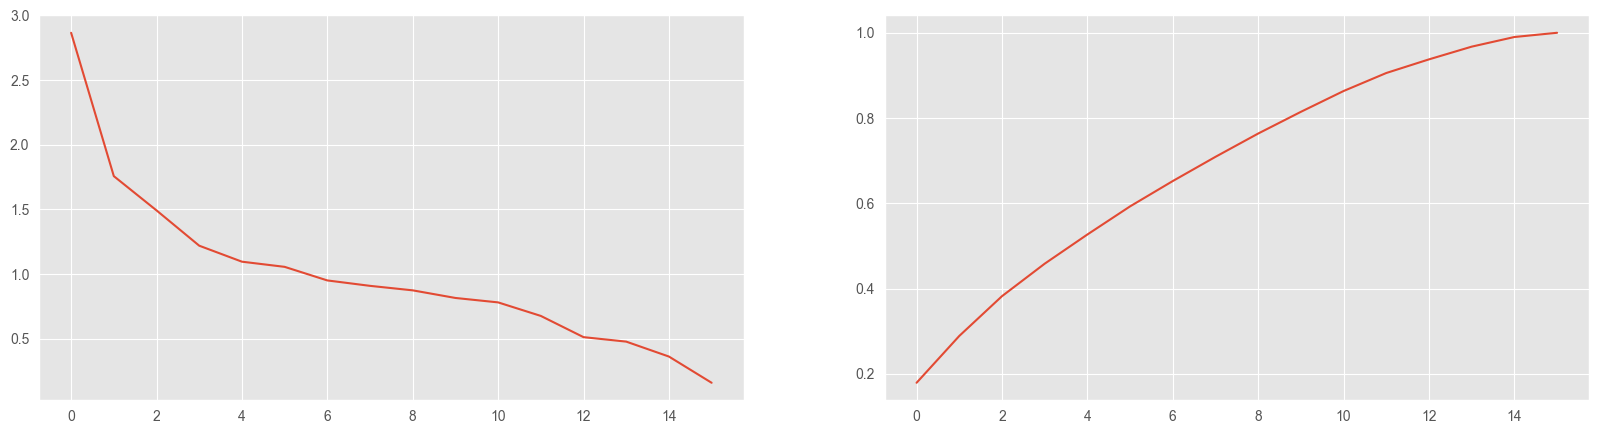

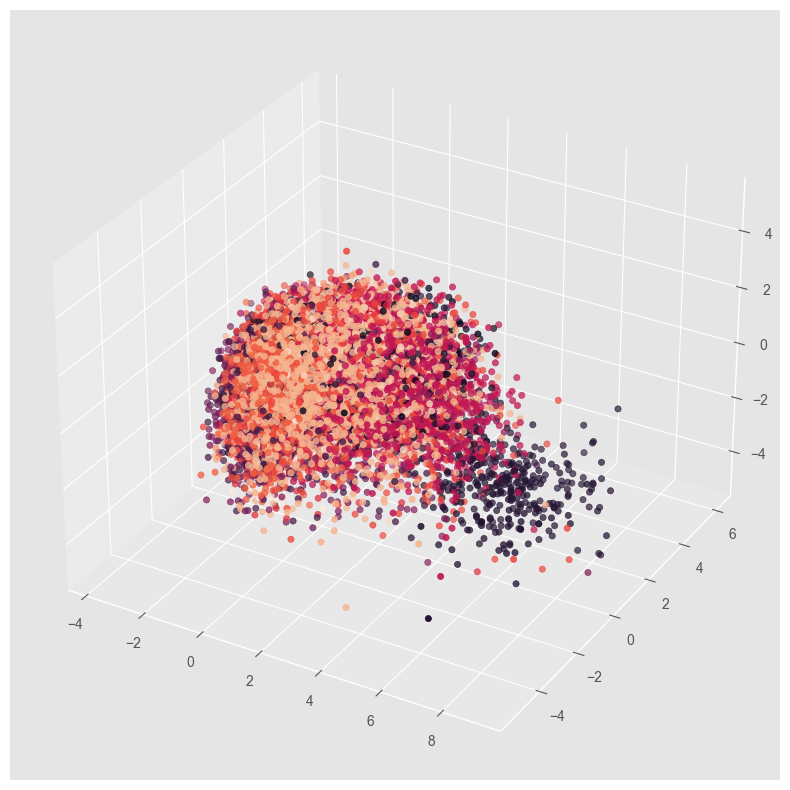

In [61]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Create PCA and train it
pca = PCA()
X = dataset_train.iloc[:, dataset_train.columns != 'genre'].to_numpy()
Y = dataset_train.iloc[:, dataset_train.columns == 'genre'].to_numpy().flatten().astype(np.int8)

scaler = StandardScaler()
X = scaler.fit_transform(X)

pca.fit(X)
var_ratios = np.cumsum(pca.explained_variance_ratio_)

# Display the curves of the explained variance and the cumulated variance
fig = plt.figure(figsize=(20, 5))

fig.add_subplot(1, 2, 1)
plt.plot(pca.explained_variance_)

fig.add_subplot(1, 2, 2)
plt.plot(var_ratios)

# Scatter the data reduced to 3 dimensions
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection='3d')
pca = PCA(n_components=3)
X_down = pca.fit_transform(X)

ax.scatter(X_down[:, 0], X_down[:, 1], X_down[:, 2], c=Y)
plt.show()


### Classification

Il est désormais temps de passer à la classification des données en entraînant divers modèles afin de comparer leur performances. Le but est de trouver le meilleur score *F1 micro* possible, autrement dit l'*accuracy*, nous allons donc comparer les différents modèles sur ce critère et ne garder que le meilleur afin de prédire le genre des données contenues dans `dataset_test`.

#### Random Forest

Le premier modèle de classification que nous essayons est un ***RandomForest***. Le modèle d'entraînement est tout à fait classique: nous séparons les données en données d'entraînement et de test que l'on utilise afin d'entraîner le modèle. Puis, nous utilisons la *cross validation* afin de déterminer la précision du modèle. Après avoir essayé différents paramètres, nous avons remarqué que les résultats étaient globalement meilleurs avec les paramètres par défaut, nous les avons donc laissé ainsi.

> Note: nous n'entraînons nos modèle que sur les données contenues dans `dataset_train`. Attention à ne pas confondre `X_test` et `Y_test` avec le `dataset_test`, qui sont obtenus à l'aide de la fonction `train_test_split` sur `dataset_train`.

Nous obtenons un score autour de *0.46* pour notre *F1* score, ce qui ne semble pas très haut à première vue, mais qui à la fois n'est pas complètement surprenant au vu de la difficulté de prédiction supposée plus tôt.

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Split the data in train and test
X_train = dataset_train.iloc[:, dataset_train.columns != 'genre'].to_numpy()
Y_train = dataset_train.iloc[:, dataset_train.columns == 'genre'].to_numpy().flatten().astype(np.int8)

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1)

# Initialise the Random Forest and calculate the F1 score
rf = RandomForestClassifier(criterion='gini', max_features=0.5, class_weight='balanced')

scores = cross_val_score(rf, X_train, Y_train, cv=5, scoring='f1_micro')
print(np.mean(scores))

Nous faisons ensuite une prédiction des genres des données de `dataset_test` à l'aide de notre ***RandomForest***, puis nous écrivons les résultat dans le fichier *.csv* correspondant en rajoutant une colonne.

Nous ne savons pas encore à ce stade si le ***RandomForest*** sera notre meilleur modèle ou non mais le code sera réutilisable dans tous les cas si nécessaire. 

In [28]:
# Fit the Random Forest and predict the genre of the dataset_test
rf.fit(X_train, Y_train)
test_pred = rf.predict(dataset_test.iloc[:].to_numpy())

for i in range(len(dataset_test)):
    dataset_test.loc[i, 'genre'] = GENRE_MAP[test_pred[i]]

dataset_test.to_csv('./dataset/spotify_dataset_test_pred.csv')

>Note: après avoir fait un ***RandomForest***, nous avons également expérimenté les ***SVM*** (Support Vector Machines), mais les performances étaient fortement plus basses que pour le ***RandomForest*** et que pour les autres modèles que nous testons ci-dessous. De plus, l'implémentation du code était très similaire, c'est pourquoi nous avons décider de le retirer du NoteBook.

#### Réseau de Neuronnes

Le second type de classification que nous décidons d'explorer sont les réseaux de neuronnes. Nous décidons pour cela de l'implémenter à l'aide de `pytorch`, bibliothèque très puissante en matière de Data Science en Python. Nous aurions pu utiliser `keras` comme vu en cours, mais étant plus à l'aise sur `pytorch` nous décidons d'utiliser cette bibliothèque plutôt.

Ici, nous commençons par créer une classe standard de réseaux de neuronnes à l'aide de `pytorch`. Également, afin de potentiellement améliorer notre puissance de calcul, nous décidons d'utiliser `cuda`, permettant de faire tourner les calculs sur la carte graphique au lieu d'utiliser le processeur. Cela peut être un gain de performances considérable selon les caractéristiques de l'ordinateur utilisé, et ayant tous les deux des ordinateurs possédant de bonnes cartes graphiques, ce choix semblait pertinent, d'autant plus que nous prevoyons de lancer les tests en parrallèles, rendant ce choix d'autant plus intéressant.

In [15]:
import torch


# First class of a standard NN model using pytorch
class NeuralNetwork(torch.nn.Module):

    # Initialisation of the NN
    def __init__(self, n1=20, n2=20, n3=20, n4=20, n5=20, p1=0, p2=0, p3=0, p4=0, p5=0):
        super().__init__()
        self.stack = torch.nn.Sequential(
            torch.nn.Linear(16, n1),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=p1),

            torch.nn.Linear(n1, n2),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=p2),

            torch.nn.Linear(n2, n3),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=p3),

            torch.nn.Linear(n3, n4),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=p4),

            torch.nn.Linear(n4, n5),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=p5),

            torch.nn.Linear(n5, 22),
        )

    # Used to predict
    def forward(self, x):
        logits = self.stack(x)
        return logits


# Detect if we're using cuda or not, meaning if we run the program on the cpu or gpu
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


Dans le code suivant, nous créons un autre type de réseau de neuronnes en utilisant des *layers* différents par rapport à précédemment permettant d'obtenir des résultats différents selon le modèle. 

Notre but avec cela est d'entraîner simultanément plusieurs types de réseaux de neuronnes en faisant varier les caractéristiques de chaque type et de comparer tous les modèles entre eux. Cela nous permettrait alors de trouver le meilleur type de réseau avec les meilleurs paramètres afin d'obtenir les meilleurs résultats lors de l'étape de prédiction.

In [29]:
import torch

# A different model of NN using different layers
class MusicGenreClassifier(torch.nn.Module):

    # Initialisation of the NN
    def __init__(self, n1=20, n2=20, n3=20, n4=20, p1=0, p2=0, p3=0, p4=0):
        super(MusicGenreClassifier, self).__init__()

        # Feature extraction layers
        self.feature_layers = torch.nn.Sequential(
            torch.nn.Linear(16, n1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(n1),
            torch.nn.Dropout(p=p1),

            torch.nn.Linear(n1, n2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(n2),
            torch.nn.Dropout(p=p2),

            torch.nn.Linear(n2, n3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(n3),
            torch.nn.Dropout(p=p3)
        )
        self.lstm_layers = torch.nn.LSTM(
            input_size=int(n3),
            hidden_size=int(n4),
            num_layers=2,
            batch_first=True,
            dropout=int(p4),
            bidirectional=True
        )

        # Classification layers
        self.classification_layers = torch.nn.Sequential(
            torch.nn.Linear(2 * n4, n4),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(n4),
            torch.nn.Dropout(p=p4),

            torch.nn.Linear(n4, 22)
        )

    def forward(self, x):
        # Forward pass through feature extraction layers
        x = self.feature_layers(x)
        lstm_out, _ = self.lstm_layers(x)
        x = self.classification_layers(lstm_out)

        return x

Ensuite, afin de pouvoir utiliser les modèles de `pytorch` créés précedemment, il nous faut transformer les données dans un format compatible avec `pytorch`. Le format voulu est le format de ***DataLoader*** qui est créé à l'aide des ***tensors*** de `pytorch`.

C'est donc ce que nous faisons ici en séparant une fois de plus le jeu de données en donées de test et d'entraînement, puis en les transformant en ***DataLoader*** pour les renvoyer à `pytorch`. Nous utilisons également le paramètre `batch_size`, valant 32 par défaut, afin d'augmenter la possibilité de personnalisation si nous le souhaitons. 

In [30]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler


# Load the data in a pytorch compatible format using tensors
def load_data_genre(batch_size=32):
    # Split the data
    X = dataset_train.iloc[:, dataset_train.columns != 'genre'].to_numpy()
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    Y = dataset_train.iloc[:, dataset_train.columns == 'genre'].to_numpy().flatten().astype(np.float64)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=12345)

    # Creates the DataLoaders using tensors
    TX_train = torch.tensor(X_train, dtype=torch.float).to(device)
    Ty_train = torch.tensor(y_train, dtype=torch.long).to(device)

    TX_test = torch.tensor(X_test, dtype=torch.float).to(device)
    Ty_test = torch.tensor(y_test, dtype=torch.long).to(device)

    t_dataset_train = TensorDataset(TX_train, Ty_train)
    t_dataset_test = TensorDataset(TX_test, Ty_test)

    train_batch = DataLoader(t_dataset_train, batch_size=batch_size, shuffle=True)
    validation_batch = DataLoader(t_dataset_test, batch_size=batch_size, shuffle=True)

    return train_batch, validation_batch

Il est enfin temps de créer le processus d'entraînement des réseaux de neuronnes.

On commence donc d'abord par récupérer les caractéristiques de la configuration donnée en paramètre et on crée notre modèle. On initialise également un *optimizer Adam*, permettant d'optimiser l'apprentissage au mieux. 

Par ailleurs, nous avons ici la possibilité d'ajouter des *checkpoints*, ce qui peut être très utile lors de l'apprentissage. Cela permet de stopper l'apprentissage à un endroit donné, puis de le reprendre par la suite en repartant du *checkpoint* configuré précédemment. Nous utilisons également le module `tqdm`, très pratique pour l'affichage dans le terminal de l'avancement d'un programme au fur et à mesure de son déroulement.

> Bien qu'il soit très pratique, le module `tqdm` peut parfois impacter sévèrement les performances d'un programme, c'est notamment pour cela que nous décidons de le mettre en tant que paramètre optionnel.

Ensuite, pour chaque *epoch*, nous entraînons notre réseau de neuronnes en nous faisant aider de l'*optimizer*, puis nous faisons les tests en calculant au fur et à mesure les pertes et la précision du modèle. La dernière partie du programme n'est qu'un petit bout de code permettant l'ajout d'un checkpoint à un endroit donné si cela était souhaité.

In [31]:
from ray.train import Checkpoint, session
import torch
import tqdm


# Train the model
def train_genre(config, MAX_EPOCH=1000, SHOW_BAR=True):
    # Initialisation
    running_losses = []
    validation_losses = []
    model = config['model'](n1=config['n1'], n2=config['n2'], n3=config['n3'], n4=config['n4'],
                            p1=config['p1'], p2=config['p2'], p3=config['p3'], p4=config['p4']).to(device)

    loss_fn = config['loss_fn']()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)

    # We load the training at a specific checkpoint if wanted
    checkpoint = session.get_checkpoint()
    if checkpoint:
        checkpoint_state = checkpoint.to_dict()
        start_epoch = checkpoint_state["epoch"]
        model.load_state_dict(checkpoint_state["net_state_dict"])
        optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    # Get the DataLoaders
    train_batch, validation_batch = load_data_genre(batch_size=config['batch_size'])

    # Used for a better display using tqdm
    if SHOW_BAR:
        bar = tqdm(total=MAX_EPOCH)
        bar.update(start_epoch)

    # Training for every epoch
    for epoch in range(start_epoch, MAX_EPOCH):
        running_loss = 0.
        model.train()

        # Computes the running loss during training
        for _, data in enumerate(train_batch):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        validation_loss = 0.
        accuracy = 0
        validation_total = 0
        model.eval()

        # Test the model and evaluates the performances
        for _, data in enumerate(validation_batch):
            # No computation of the gradient for better performances
            with torch.no_grad():
                inputs, labels = data
                outputs = model(inputs).squeeze()
                loss = loss_fn(outputs, labels.squeeze())
                validation_loss += loss.item()
                validation_total += labels.size(0)
                accuracy += (torch.argmax(outputs, 1) == labels).sum().item()

        running_loss /= len(train_batch)
        validation_loss /= len(validation_batch)
        running_losses.append(running_loss)
        validation_losses.append(validation_loss)

        # Creates a checkpoint if necessary
        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            path = os.path.join(temp_checkpoint_dir, "checkpoint.pt")
            torch.save(
                (model.state_dict(), optimizer.state_dict()), path
            )
            checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
            ray.train.report(
                {"loss": validation_loss, "accuracy": accuracy / validation_total},
                checkpoint=checkpoint,
            )

        # Handles a proper display
        if SHOW_BAR:
            bar.update(1)
            bar.set_postfix(str=f"Running loss: {running_loss:.5f} - Validation loss: {validation_loss:.5f}.")
    if SHOW_BAR:
        bar.close()

    return running_losses, validation_losses, model

Il est désormais temps d'utiliser tout ce que nous avons fait précédemment et d'entraîner nos différents modèles en faisant varier les paramètres afin de trouver la meilleure configuration possible. Pour faire cela nous utilisons `ray[tune]`, une librairie Python permettant notamment de faire varier divers paramètres, le tout en lançant les processus en parallèles. 

Par exemple, dans l'objet config, `ray[tune]` nous permet d'essayer toutes les combinaisons possibles de paramètres pour `n1, n2, n3, n4` allant de 1 à 4096, ainsi que pour tous les autres paramètres, comme notamment le `batch_size` et bien évidemment le modèle choisi parmi les deux que nous avons créé. Nous utilisons un ***scheduler*** de type ***ASHA*** (Async Successive Halving) permettant de stopper les configurations non-performantes le plus tôt possible afin de tester un maximum de combinaisons rapidement, contrairement à une méthode *brute-force* classique. Cela représente une énorme quantité de possibilités et il est donc très intéressant de pouvoir tester autant de combinaisons simultanément, bien que cela prenne beaucoup de temps à s'exécuter, même en possédant un bon ordinateur. 

Nous comparons donc tous les modèles en se basant sur le critère d'*accuracy* et nous affichons la configuration utilisée pour obtenir les meilleurs résultats.

In [34]:
from ray.tune import JupyterNotebookReporter
from functools import partial
from ray.tune.schedulers import ASHAScheduler
from ray import tune

# Test a lot of combination of parameters for the NN using tuning
config = {
    "n1": tune.choice(np.arange(1, 4096, 1)),
    "n2": tune.choice(np.arange(1, 4096, 1)),
    "n3": tune.choice(np.arange(1, 4096, 1)),
    "n4": tune.choice(np.arange(1, 4096, 1)),
    "n5": tune.choice(np.arange(1, 1000, 1)),
    "p1": tune.choice(np.linspace(0, 1, 100)),
    "p2": tune.choice(np.linspace(0, 1, 100)),
    "p3": tune.choice(np.linspace(0, 1, 100)),
    "p4": tune.choice(np.linspace(0, 1, 100)),
    "p5": tune.choice(np.linspace(0, 1, 50)),
    "lr": tune.loguniform(1e-5, 1e-2),
    "batch_size": tune.choice([256, 512, 1024, 2048]),
    'model': tune.choice([NeuralNetwork, MusicGenreClassifier]),
    'loss_fn': torch.nn.CrossEntropyLoss,
    'loader': load_data_genre
}
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=200,
    grace_period=1,
    reduction_factor=2,
)

# Handles the results
result = tune.run(
    partial(train_genre, SHOW_BAR=False),
    resources_per_trial={"cpu": 16, "gpu": 1},
    config=config,
    num_samples=2,
    scheduler=scheduler,
    progress_reporter=JupyterNotebookReporter()
)

# Find the best config on the accuracy parameter
best_trial = result.get_best_trial("accuracy", "max", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")

2024-01-25 10:59:08,887	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,accuracy,loss,should_checkpoint
train_genre_61f9b_00000,0.0283417,3.12505,True


2024-01-25 11:03:29,138	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'n1': ('__ref_ph', 'c98eb873'), 'n2': ('__ref_ph', '645d6aed'), 'n3': ('__ref_ph', '4cbc65a0'), 'n4': ('__ref_ph', '40741b28')}
2024-01-25 11:03:44,398	INFO tune.py:1042 -- Total run time: 275.51 seconds (260.16 seconds for the tuning loop).


Best trial config: {'n1': 3003, 'n2': 2753, 'n3': 2447, 'n4': 1192, 'p1': 0.2828282828282829, 'p2': 0.696969696969697, 'p3': 0.696969696969697, 'p4': 0.98989898989899, 'lr': 1.3937484665543055e-05, 'batch_size': 512, 'model': <class '__main__.NeuralNetwork'>, 'loss_fn': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'loader': <function load_data_genre at 0x0000023DE0A212D0>}
Best trial final validation loss: 2.169679355621338
Best trial final validation accuracy: 0.370304991664215


Maintenant que nous avons trouvé une configuration satisfaisante, nous entraînons le modèle avec la meilleure configuration puis on récupère les courbes de pertes que nous traçons sur le graphe ci-dessous. Nous utilisons les courbes afin de détecter que nous ne sommes pas dans un cas d'*under-fitting* ou d'*over-fitting* et nous relançons l'entraînement en modifiant le paramètre *MAX_EPOCH* en fonction du cas dans lequel nous nous trouvons. 

  0%|          | 0/150 [00:00<?, ?it/s]

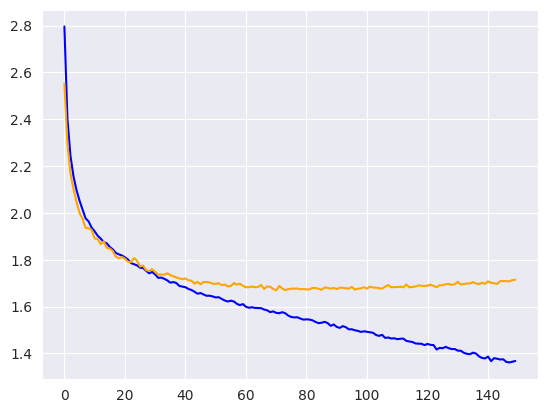

In [86]:
import matplotlib.pyplot as plt

# config = {'n1': 2565, 'n2': 4046, 'n3': 1828, 'n4': 2648, 'p1': 0.5757575757575758, 'p2': 0.7676767676767677,
#           'p3': 0.686868686868687, 'p4': 0.08080808080808081, 'lr': 0.00024444515305828874, 'batch_size': 1024,
#           'model': NeuralNetwork, 'loss_fn': torch.nn.CrossEntropyLoss}

# Uses the best config found previously and display the curves of losses
r_l, v_l, model = train_genre(best_trial.config, MAX_EPOCH=150)
plt.plot(r_l, color='blue')
plt.plot(v_l, color='orange')

Nous regardons maintenant l'*accuracy* de prédiction de notre modèle que nous venons d'entraîner. Nous obtenons un score autour de 0.45, légèrement plus faible que pour le ***RandomForest*** qui reste plus performant, et qui de plus prends beaucoup moins de temps à s'entraîner.

In [20]:
from sklearn.metrics import f1_score
import torch

# Predict the genre using the NN and print the accuracy of the model
train_batch, validation_batch = load_data_genre(batch_size=best_trial.config['batch_size'])

y_preds = []
y_true = []

for i, data in enumerate(validation_batch):
    inputs, labels = data
    outputs = torch.argmax(model(inputs).squeeze(), 1).cpu()
    y_preds.extend(outputs)
    y_true.extend(labels.cpu())

print(f1_score(y_true, y_preds, average='micro'))

NameError: name 'best_trial' is not defined

#### Boosting

Pour ce troisième modèle, nous décidons d'essayer `xgboost`, une autre librairie très populaire dans le monde du *machine learning* en Python, permettant de faire une methode de type *boosting* sur des arbres. De plus, l'implémentation se fait relativement facilement car elle reste assez similaire à celle utilisée précédemment avec `pytorch`.

Nous créons donc la méthode permettant d'entraîner un modèle selon une configuration donnée, en utilisant cette fois des données compatibles avec `xgboost` qui utilise les ***DMatrix***, une classe parfaitement optimisée pour la rapidité et l'utilisation de la mémoire. La syntaxe est relativement explicite, nous séparons toujours notre jeu de données en données d'entraînement et de test, puis nous utilisons la méthode `train` permettant d'entraîner notre modèle.

In [252]:
import xgboost

# Training method
def train_boost_genre(config):
    # Split the data
    X = dataset_train.iloc[:, dataset_train.columns != 'genre'].to_numpy()
    y = dataset_train.iloc[:, dataset_train.columns == 'genre'].to_numpy().flatten().astype(np.int8)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12345)

    # Creates the XGBoost model
    train_set = xgboost.DMatrix(X_train, label=y_train)
    test_set = xgboost.DMatrix(X_test, label=y_test)
    results = {}

    booster = xgboost.train(
        config['params'],
        train_set,
        evals=[(test_set, "eval")],
        evals_result=results,
        verbose_eval=False,
        early_stopping_rounds=config['early_stopping_rounds'],
        xgb_model=config['model']
    )

    # Predict the genre and display the accuracy
    y_pred = booster.predict(test_set)
    accuracy = f1_score(y_test, y_pred, average='micro')

    train.report({"accuracy": accuracy, "done": True, "merror": results['eval']['merror'][-1],
                  "mlogloss": results['eval']['mlogloss'][-1], "model": booster})

    return booster, accuracy, results

En s'aidant à nouveau de `ray[tune]`, nous faisons varier les paramètres et testons ainsi le plus de combinaisons possibles de modèles en ne gardant que la meilleure. Cette fois encore, la comparaison se fait au niveau du paramètre *accuracy*, nous permettant de garder la configuration qui a eu les meilleures performances lors de la prédiction des données de test.

In [253]:
from ray import tune

# Tries a lot of configuration by tuning the parameters
b = None
config = {
    'params': {
        "objective": "multi:softmax",
        "eval_metric": ["merror", "mlogloss"],
        "max_depth": tune.randint(1, 200),
        "min_child_weight": tune.uniform(0, 20),
        "subsample": tune.uniform(0.2, 1.0),
        "eta": tune.loguniform(1e-7, 1e-1),
        "num_class": len(GENRE_MAP),
        "tree_method": tune.choice(['auto', 'exact', 'approx', 'hist'])
    },
    "early_stopping_rounds": tune.randint(1, 10000),
    "model": b
}
scheduler = ASHAScheduler(
    max_t=50, grace_period=5, reduction_factor=2
)
tuner = tune.Tuner(
    train_boost_genre,
    tune_config=tune.TuneConfig(
        metric="mlogloss",
        mode="min",
        num_samples=20,
        scheduler=scheduler
    ),
    param_space=config,
)

# Find the best config on the accuracy parameter
results = tuner.fit()
best_trial = results.get_best_result("accuracy", "max", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation accuracy: {best_trial.metrics['accuracy']:.4f}")
print(f"Best trial final validation error: {best_trial.metrics['merror']:.4f}")
print(f"Best trial final validation logloss: {best_trial.metrics['mlogloss']:.4f}")
print(best_trial)

2024-01-25 14:31:07,554	INFO tune.py:1042 -- Total run time: 20.18 seconds (19.70 seconds for the tuning loop).


Best trial config: {'params': {'objective': 'multi:softmax', 'eval_metric': ['merror', 'mlogloss'], 'max_depth': 152, 'min_child_weight': 3.9450762565384756, 'subsample': 0.4908829757482033, 'eta': 0.028025536344085295, 'num_class': 22, 'tree_method': 'auto'}, 'early_stopping_rounds': 4288, 'model': None}
Best trial final validation accuracy: 0.4604
Best trial final validation error: 0.5396
Best trial final validation logloss: 2.6152
Result(
  metrics={'accuracy': 0.4603921568627451, 'merror': 0.5396078431372549, 'mlogloss': 2.6152189608648713, 'model': <xgboost.core.Booster object at 0x0000023FA2D4DD80>},
  path='C:/Users/Pierre/ray_results/train_boost_genre_2024-01-25_14-30-47/train_boost_genre_f2d12_00011_11_early_stopping_rounds=4288,eta=0.0280,max_depth=152,min_child_weight=3.9451,subsample=0.4909,tree_2024-01-25_14-30-48',
  filesystem='local',
  checkpoint=None
)


Après avoir obtenu la meilleure configuration trouvée, on poursuit l'entraînement de ce modèle en essayant de ne pas faire d'*over-fitting*. Arpès quelques tests, nous avons trouvé que faire 16 ré-entraînements nous offrait les meilleurs résultats.

On en profite pour récupérer les valeurs de l'*accuracy*, l'erreur et la perte logarithmique que nous traçons sur les graphes ci-dessous, nous peremetant de trouver une *accuracy* à 0.4496, la meilleure que nous avons trouvé !

  0%|          | 0/16 [00:00<?, ?it/s]

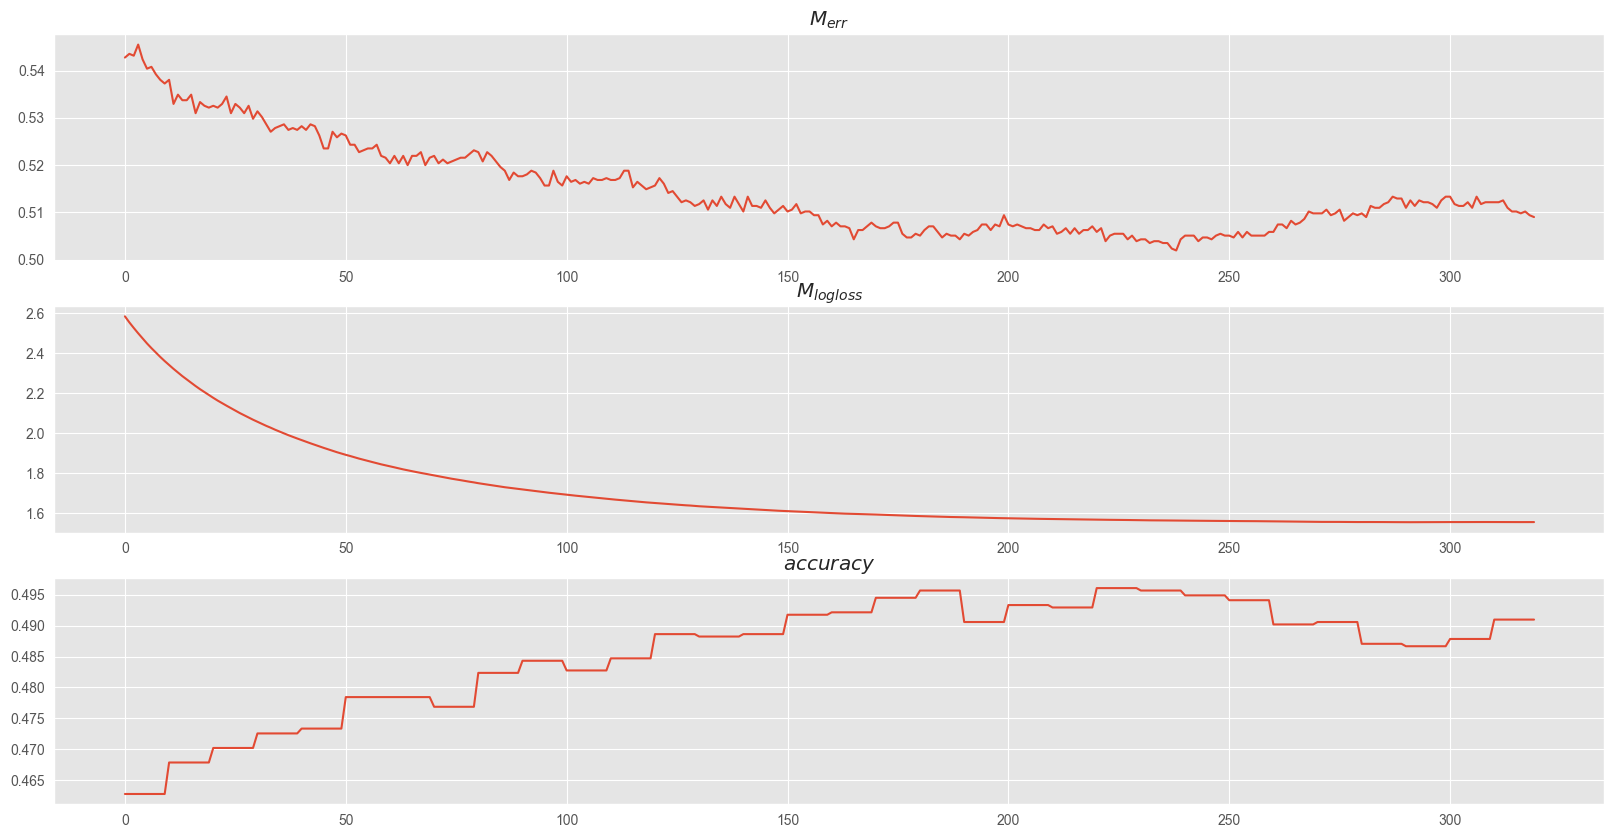

Best accuracy: 0.49607843137254903


In [257]:
from tqdm.notebook import trange
import matplotlib.pyplot as plt

b = best_trial.metrics['model'] if best_trial is not None else None
merrs = []
mloglosss = []
accs = []

# Train a few times the same model and save the error, log loss and accuracy
for _ in trange(16):
    b, acc, res = train_boost_genre({
        'params': best_trial.config['params'],
        "early_stopping_rounds": best_trial.config['early_stopping_rounds'],
        'model': b
    })
    merrs.extend(res['eval']['merror'])
    mloglosss.extend(res['eval']['mlogloss'])
    accs.extend([acc] * len(res['eval']['mlogloss']))

# Plot the 3 curves and find the best accuracy
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(3, 1, 1)
plt.plot(merrs)
plt.title('$M_{err}$')
fig.add_subplot(3, 1, 2)
plt.plot(mloglosss)
plt.title('$M_{logloss}$')
fig.add_subplot(3, 1, 3)
plt.plot(accs)
plt.title('$accuracy$')
plt.show()

print(f"Best accuracy: {max(accs)}")

Pour terminer, nous utilisons ce modèle qui semble être le plus satisfaisant parmis les trois essayés et nous faisons comme précédemment: on prédit les genre des données contenues dans `dataset_test`, puis on met à jour le fichier *.csv* que nous pouvons désormais mettre en ligne sur MylearningSpace !

In [256]:
from xgboost import DMatrix

# Predict the genres of the dataset_test and write them in the csv file
test_pred = b.predict(DMatrix(dataset_test.iloc[:, dataset_test.columns != 'genre'].to_numpy()))

for i in range(len(dataset_test)):
    dataset_test.loc[i, 'genre'] = GENRE_MAP[int(test_pred[i])]

dataset_test.to_csv('./dataset/spotify_dataset_test_pred.csv')

## Exercice 2

Nous travaillons désormais sur un nouveau set de données, contenues dans le fichier *spotify_dataset_subset.csv*, avec cette fois pour objectif de prédire la popularité d'une musique. En regardant rapidement les données, nous nous rendons compte que les genres sont désormais représentés par des listes de genres, rendant la prédiction beaucoup plus compliquée. On pourrait se dire que les genres n'influent pas sur la popularités au vu du résultat de la matrice des corrélations à l'exercice 1, cependant, après un rapide test sur un modèle de *RandomForest*, il est clair qu'il est nécessaire de les prendre en compte d'une façon ou d'une autre.

### Analyse des données

Nous parcourons donc le dataset afin d'en remplacer certaines caractéristiques: de la même façon qu'à l'exercice 1, nous remplaçons les *release_dates* par un *timestamp*. Également, nous rajoutons une colonne contenant l'id de l'artiste en encodant le nom de l'artiste afin d'obtenir un entier. Cela nous permettra d'éliminer la colonne *artiste_name* puisqu'elle sera représentée par la colonne *id*.

Enfin, pour les genres, nous transformons la colonne *genres* par plusieurs nouvelles colonnes au format *genre_nom*, valant 1 si la musique est du genre donné, et 0 sinon. Pour cela nous utilisons `ast.literal_eval`, permettant de récupérer la liste contenue à l'endroit du dataset, puis on définit sa valeur à 1, créant ainsi une colonne si la colonne n'existe pas encore, ou vient remplir la colonne si elle existe. Il suffit ensuite simplement de remplacer les valeurs à `nan` par des 0 afin que les colonnes représentent des booléens. On remarque en sortie que le programme nous compte 1766 colonnes.

In [2]:

import datetime
import ast
import numpy as np
import pandas
import hashlib

import warnings

warnings.simplefilter(action='ignore', category=pandas.errors.PerformanceWarning)

dataset = pandas.read_csv("dataset/spotify_dataset_subset.csv")

# Transform the explicit boolan in 0 and 1
dataset['explicit'] = dataset['explicit'].astype(np.int8)

for i, date in enumerate(dataset['release_date']):
    # Detect the date format and replace it with a utc timestamp for the train dataset
    if len(date.split('-')) == 3:
        dataset.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y-%m-%d").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    elif len(date.split('-')) == 2:
        dataset.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y-%m").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    elif len(date.split('-')) == 1:
        dataset.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    else:
        print(date)

    # Encode the artist_name into the artist_id
    dataset.loc[i, 'artist_id'] = int.from_bytes(hashlib.sha256(dataset.loc[i, 'artist_name'].encode()).digest(), 'big')

    # Creates a sub column with the genre and set the value to 1
    genres = ast.literal_eval(dataset.loc[i, 'genres'])
    for genre in genres:
        dataset.loc[i, f"genre_{genre.lower().replace(' ', '_')}"] = 1

# Replaces all the nan values by 0
dataset.replace(np.nan, 0, inplace=True)

print(f"Using {len(dataset.columns)} columns")

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_15388\917084847.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas


Using 1766 columns


Maintenant que les données sont dans un format plus facile à traiter, nous pouvons tenter de visualiser les données à l'aide d'un *PCA*. Pour cela, on sépare nos données comme les fois précédentes, en retirant pour *X* les colonnes `genres, id, track_name, artist_name, popularity`. La raison étant, `popularity` est la colonne à prédire, la colonne `genres` n'est plus intéressante puisque nous avons créé une colonne par genre au lieu d'avoir une colonne contenant tous les genres d'une chanson donnée, la colonne `artiste_name` est désormais représentée par `artist_id`, et enfin nous avons supposé que le nom d'une chanson ainsi que son id n'etait pas intéressant étant donné que ce sont (en principe) des données uniques pour chaque chanson (à l'exception de certains titres de chanson mais cela reste très rare).

On crée d'abord notre *PCA*, puis on affiche les graphes de la variance et de la variance cumulée afin de déterminer certaines caractéristiques de nos données. On remarque que pour garder 80% de l'information il faut garder autour de 800 composantes, ce qui prouve l'utilité et l'importance de la séparation des genres en colonnes distinctes.

Enfin, on utilise cette information en créant notre *PCA* avec 800 composantes, puis on affiche les données en 3D en ne regardant que les 3 premières composantes, qui sont (par construction du *PCA*) les plus représentatives des données étudiées. On remarque une forme assez singulière pour nos données, qui prends une forme d'étoile. Pour autant, il est difficile de faire des conclusions ou suppositions au vu de cet affichage étant donné que chaque branche contient une grande variété de donnée au vu des couleurs des points affichés.

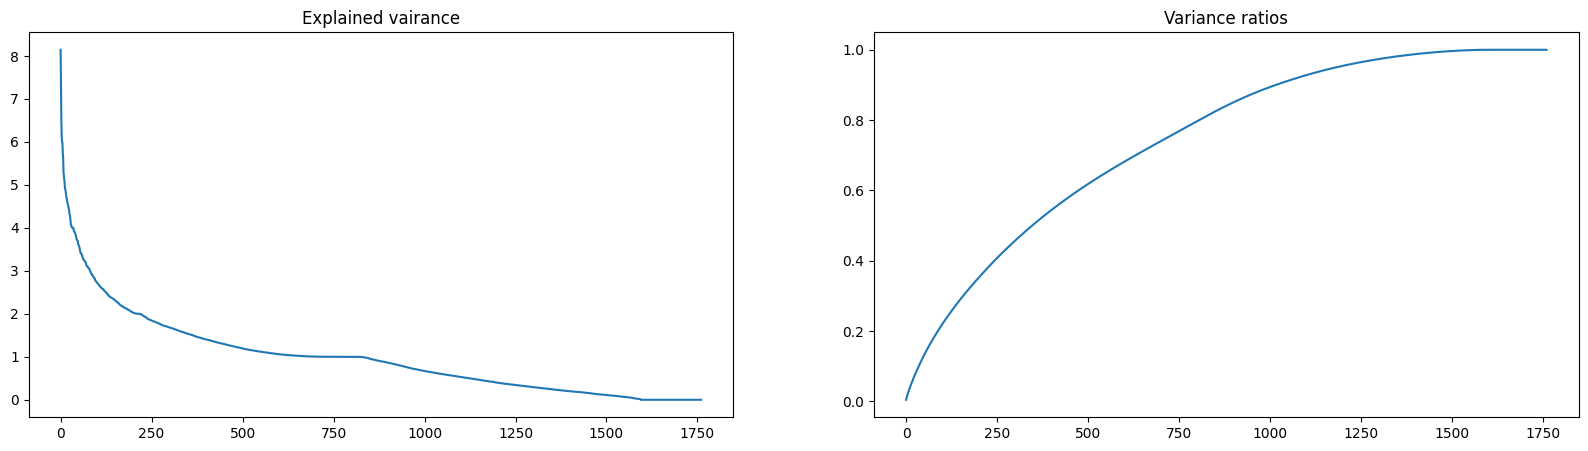

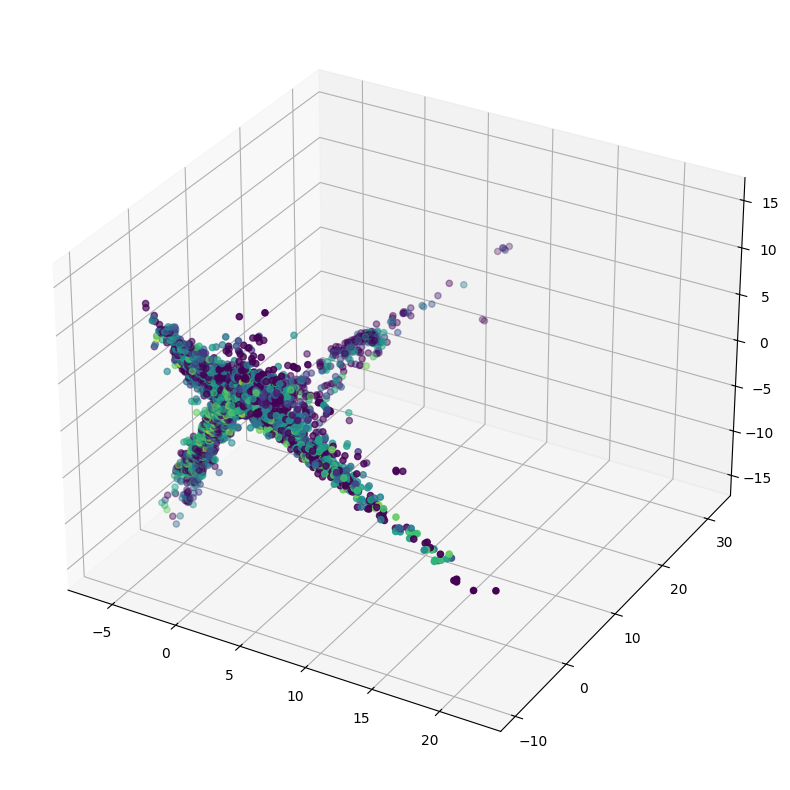

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Creation of the PCA
pca = PCA()
X = dataset[dataset.columns.difference(['genres', 'id', 'track_name', 'artist_name', 'popularity'])].to_numpy()
Y = dataset.iloc[:, dataset.columns == 'popularity'].to_numpy().flatten().astype(np.int8)

scaler = StandardScaler()
X = scaler.fit_transform(X)

pca.fit(X)
var_ratios = np.cumsum(pca.explained_variance_ratio_)

# Display of variance and cumulated variance
fig = plt.figure(figsize=(20, 5))
fig.add_subplot(1, 2, 1)
plt.plot(pca.explained_variance_)
plt.title('Explained vairance')

fig.add_subplot(1, 2, 2)
plt.plot(var_ratios)
plt.title('Variance ratios')

# 3D display of the pca with 800 components
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection='3d')
pca = PCA(n_components=800)
X_down = pca.fit_transform(X)

ax.scatter(X_down[:, 0], X_down[:, 1], X_down[:, 2], c=Y)
plt.show()

Une seconde méthode de visualisation que nous essayons est le *TSNE* (t-distributed stochastic neighbor embedding). Nous construisons notre *TSNE* de la même façon que le *PCA*, cette fois en ne gardant que 3 composantes afin de faire un affichage en 3 dimensions (La construction du TSNE nous impose *n_components* <= 4 donc on ne peut pas faire avec 800 composantes comme pour le *PCA*).

Cette fois encore, l'affichage nous montre un gros bloc de points de toutes les couleurs, confirmant l'idée que les classes ne sont pas facile à distinguer. Cette représentation nous confirme notamment que nous ne pouvons pas vraiment utiliser de méthodes comme le clustering ou la régression car il sera trop difficile de séparer les classes de façon satisfaisante.

1.1881358623504639


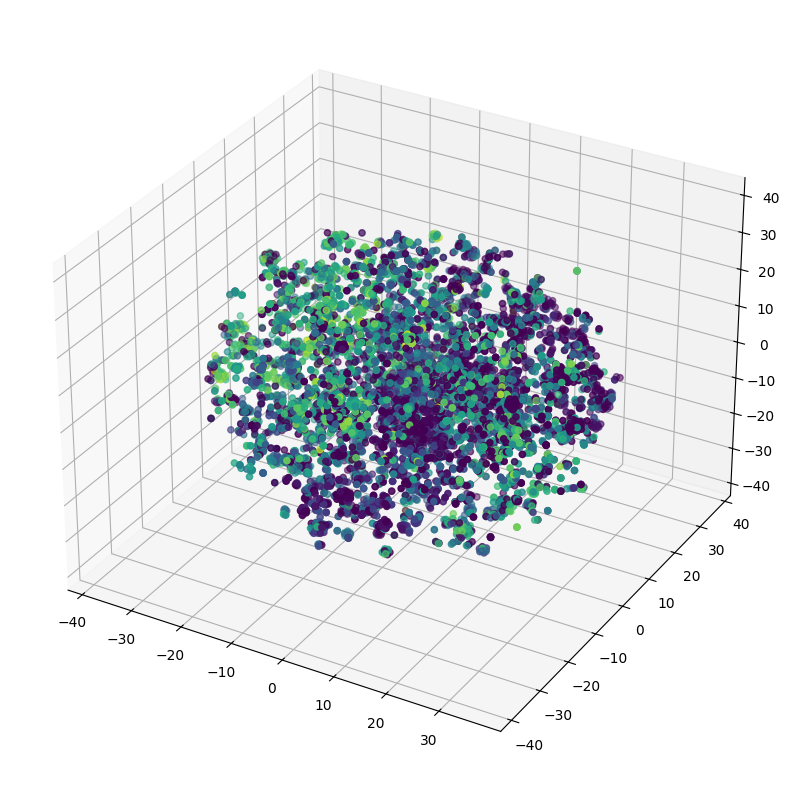

In [5]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Same way of seperating the data
X = dataset[dataset.columns.difference(['genres', 'id', 'track_name', 'artist_name', 'popularity'])].to_numpy()
Y = dataset.iloc[:, dataset.columns == 'popularity'].to_numpy().flatten().astype(np.int8)

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Creation of the TSNE with 3 components
tnse = TSNE(n_components=3)

# 3D display of the points
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection='3d')
X_down = tnse.fit_transform(X)
print(tnse.kl_divergence_)

ax.scatter(X_down[:, 0], X_down[:, 1], X_down[:, 2], c=Y)
plt.show()

### Classification

La prochaine étape est maintenant l'entraînement d'un modèle afin de faire de la prédiction de la popularité d'une musique. Étant donné que le modèle est relativement similaire, nous essayons les modèles que nous avions utilisé à l'exercice 1, appliqué à l'exercice 2.

Nous avons commencé par les réseaux de neuronnes, cependant, les données étaient trop volumineuses pour `ray[tune]` étant donné qu'il y a beaucoup de colonnes dû à la grande quantité de genres. Il était donc impossible de faire du *fine tuning* sur les paramètres et il était donc difficile d'entraîner nos réseaux de neuronnes autrement. Nous avons essayé quelques configurations manuelles malgré tout, mais les résultats n'ont pas été concluant.

#### Boosting

Nous décidons alors de nous centrer sur le meilleur modèle que nous avions à l'exercice 1: le *boosting* avec `xgboost`. Il ne nous semblait pas pertinent de refaire des *RandomForest* non plus étant donné que `xgboost` utilise des arbres directement. C'est donc ce que nous faisons dans le programme ci-dessous, qui implémente le boosting d'une façon tout à fait similaire à précedemment.

In [6]:
import xgboost
from sklearn.model_selection import train_test_split


def train_boost_popularity(config, model):
    # Spliting the data
    X = dataset[
        dataset.columns.difference(['genres', 'id', 'track_name', 'artist_name', 'popularity', 'artist_id'])].to_numpy()
    y = dataset.iloc[:, dataset.columns == 'popularity'].to_numpy().flatten()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12345)

    # Creation of the DMatrix
    train_set = xgboost.DMatrix(X_train, label=y_train)
    test_set = xgboost.DMatrix(X_test, label=y_test)
    results = {}

    # Training the model
    booster = xgboost.train(
        params=config,
        dtrain=train_set,
        evals=[(test_set, "eval")],
        evals_result=results,
        verbose_eval=False,
        early_stopping_rounds=10,
        xgb_model=model
    )

    return booster, results

ModuleNotFoundError: No module named 'xgboost'

Par le même principe qu'à l'exercice précédent, nous entraînons notre modèle une certaine quantité de fois en essayant d'éviter l'*over-fitting*, cette fois-ci en se basant sur le critère de la *RMSE* (Root Mean Square Error), étant donné qu'il serait irréaliste de chercher à prédire la popularité au chiffre près. 

Après ré-entraînement du modèle, on trace la courbe de la *RMSE* et on remarque qu'elle tourne autour de 24, en descendant à un minimum autour de 22,7, ce qui semble assez satisfaisant au vu du problème.

  0%|          | 0/4 [00:00<?, ?it/s]

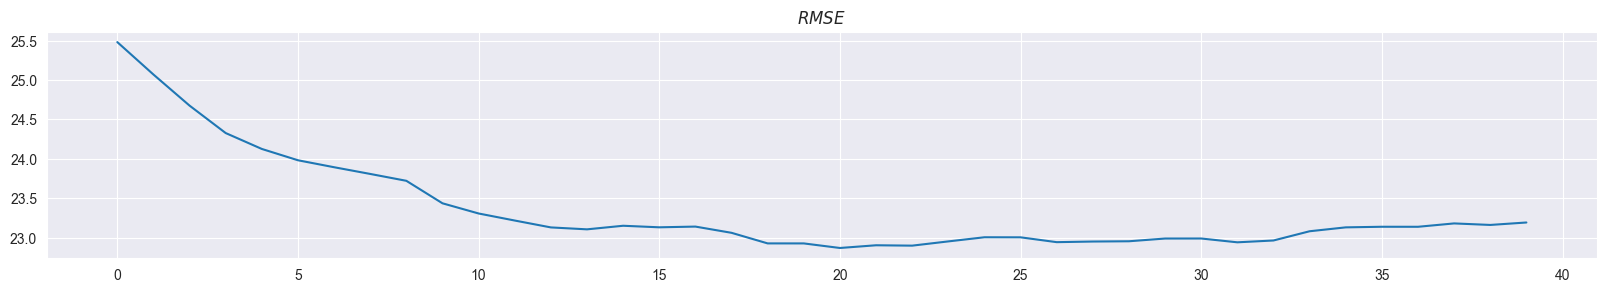

In [ ]:
from tqdm.notebook import trange
import matplotlib.pyplot as plt

# Booster
b = None

config = {
    "objective": "reg:squarederror",
    "eval_metric": ["rmse"],
    "max_depth": 100,
    "min_child_weight": 1,
    "subsample": 0.2,
    "eta": 1e-1,
    "tree_method": 'auto'
}
rmses = []

# Train the model a few times and saves the rmse
for _ in trange(4):
    b, res = train_boost_popularity(config, b)
    rmses.extend(res['eval']['rmse'])

# Plot the curve of the RMSE
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(3, 1, 1)
plt.plot(rmses)
plt.title('$RMSE$')

plt.show()


Maintenant que nous avons un booster entraîné avec de bonnes performances, il est temps de le mettre à l'épreuve avec nos données de test en prédisant la popularité de nos données. De là, nous avons décidé de nous référer à deux types de scores: la *MAE* (Mean Absolute Error) ainsi qu'à un score "créé" pour notre cas de figure.

Ce score en question fonctionne de la façon suivante: si la popularité prédite est comprise autour de plus ou moins 10 de la popularité réelle, alors nous avons prédit correctement, sinon nous avons mal prédit. Cela nous permet donc ensuite de faire un pourcentage des données correctement prédites ou non.

Les résultats sont les suivants: une *MAE* autour de 11.5 et environ 54% de données prédites de façon satisfaisantes. Une fois encore, nous considérons les résultats comme globalement satisfaisants en comparaison aux performances obtenues à l'exercice 1 et à la complexité des données à prédire.

In [ ]:
# Prediction using the booster
y_true = dataset.iloc[:, dataset.columns == 'popularity'].to_numpy().flatten()
y_pred = b.predict(xgboost.DMatrix(dataset[dataset.columns.difference(['genres', 'id', 'track_name', 'artist_name', 'popularity', 'artist_id'])].to_numpy()))

me = 0
score = 0

# Computation of the scores
for i in range(len(y_true)):
    diff = abs(y_pred[i] - y_true[i])
    me += diff
    if diff < 10:
        score += 1

print(f"MAE: {me / len(y_true):.4f}")
print(f"Score: {score / len(y_true) * 100:.2f}%")

MAE: 11.5290
Score: 54.30%


#### Support Vector Regression

Pour terminer, nous décidons d'essayer un dernier type de classification: les *SVM* (Support Vector Machines) et plus particulièrement ici les *SVR* (Support Vector Regression). Le programme est relativement simple et très similaire à d'autres processus expliqué précedemment: nous séparons les données puis on entraîne notre modèle avec. Enfin, nous prédisons nos données de test, et nous calculons la *RMSE* entre les données réelles et les données prédites.

La réponse est assez claire: presque 680 de *RMSE*, nous pouvons aisément conclure que ce modèle n'est pas du tout adapté à notre situation et qu'il est bien moins performant que le *boosting* une fois de plus.

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn import svm

svr = svm.SVR()

# Spliting the data
X = dataset[dataset.columns.difference(['genres', 'id', 'track_name', 'artist_name', 'popularity'])].to_numpy()
Y = dataset.loc[:, dataset.columns == 'popularity'].to_numpy().flatten().astype(np.float64)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=12345)

# Train the svr and computes the RMSE using the prediction
svr.fit(X_train, y_train)

print(mean_squared_error(y_test, svr.predict(X_test)))

679.694559670885


## Exercice 3

Maintenant que nous savons classer des données de façon relativement satisfaisante, nous pouvons essayer de faire des recommandations aux utilisateurs de la plateforme. Pour cela, il nous faut détecter si deux musiques sont "proches", afin de savoir ou non si elle est susceptible de plaire à l'utilisateur.

### Formatage des données

Comme les fois précédentes, la première étape est de remettre les données sous un format qu'il est possible de traiter pour notre apprentissage. Nous remplaçons donc les `release_dates` par un `timestamp` comme vu précedemment, et également nous retirons les duplications afin de limiter légèrement la quantité de données à traiter.

Le seul problème que nous rencontrons lors de cette étape est que nous sommes contraints à ne pas pouvoir prendre en compte la colonne `artists` en l'état. La raison étant que, de la même façon que pour les `genres` à l'exercice 2, les artistes sont désormais représentés sous forme de liste d'artistes. Nous avons donc essayé de faire la même méthode que précédemment en créant une colonne par artiste, mais cela a résulté en un dataset contenant plus de 32 000 colonnes, ce qui était bien trop gros pour l'entraînement du modèle. 

Pour pallier à ce problème, nous avons essayé de simplifier la colonne des artistes en ne gardant que le premier artiste de la liste, qui souvent est l'artiste principal de la musique en question. Cette technique fonctione très bien, cependant, l'algorithme de détection des musiques proches va détecter presque systématiquement que les musiques les plus proches sont celles écrites par le même artiste, créant ainsi des playlists entières de musiques d'un seul et même artiste. Bien que cela puisse avoir un intérêt, nous avons trouvé qu'il était plus intéressant d'avoir une certaine diversité au sein des recommandations, donc nous avons décidé de simplement retirer la colonne des artistes dans notre entraînement afin de baser les recommandations sur des critères plus variés.

In [22]:
from tqdm.notebook import tqdm
import datetime
import numpy as np
import pandas

import warnings

warnings.simplefilter(action='ignore', category=pandas.errors.PerformanceWarning)

dataset = pandas.read_csv("dataset/recommendation_spotify.csv")

dataset['explicit'] = dataset['explicit'].astype(np.int8)

for i in range(dataset.shape[0]):
    # Detect the date format and replace it with a utc timestamp for the train dataset
    date = dataset.iloc[i]['release_date']
    if len(date.split('-')) == 3:
        dataset.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y-%m-%d").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    elif len(date.split('-')) == 2:
        dataset.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y-%m").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    elif len(date.split('-')) == 1:
        dataset.loc[i, 'release_date'] = datetime.datetime.strptime(date, "%Y").replace(
            tzinfo=datetime.timezone.utc).timestamp()
    else:
        print(date)

# Remove the duplicates in the dataset
dataset.drop_duplicates(inplace=True, subset=['id'])
print(f"Using {len(dataset.columns)} columns and {len(dataset)} lines.")

Using 19 columns and 172230 lines.


### Détection des voisins

Nous allons utiliser la méthode des ***Nearest Neighbors*** afin de trouver les musiques les plus similaires à une musique donnée en fonction de ses particularités. Afin de construire une playlist d'une dizaine de musiques, il suffit alors de trouver les 10 plus proches voisins afin de proposer une playlist la plus pertinente possible (méthode des *KNN*).

Nous décidons ici de faire un premier calcul des plus proches voisins en renseignant donc 11 voisins (un point est toujours voisin de lui-même) et en renseignant le mode sur `auto` afin que l'algorithme trouve le meilleur paramètre à choisir directement.

In [27]:
from sklearn.neighbors import NearestNeighbors

# Extract the data and find the nearest 10 neighbors for every song
X = dataset[dataset.columns.difference(['artists', 'id', 'name'])].to_numpy()

nbrs = NearestNeighbors(n_neighbors=11, algorithm='auto').fit(X)
distances, indices = nbrs.kneighbors(X)

Ensuite nous créons deux méthodes qui vont nous aider pour faire les playlists: une première méthode que l'on nomme `make_playlist`, qui prend en paramètre l'id d'une musique et le nombre de voisins à trouver, puis qui va effectuer l'algorithme des *KNN* pour cette musique.

La deuxième méthode `make_playlist_user` est légèrement plus complexe, on récupère une liste de musiques, et on va renvoyer une playlist en fonction de cette liste de musiques. Pour faire cela, on attribue un poids à chaque musique de la liste, et on va créer des petites playlists autour de chaque musique de la liste en fonction de son poids, qui est lui-même calculé en fonction du nombre de fois que la musique a été écoutée. Voici un exemple simpliste: si on donne une liste contenant la musique A et la musique B, que la musique A a été écoutée 10 fois et la musique B 1 fois, on va renvoyer une playlist contenant 10 fois plus de musiques proches de la musique A que de la musique B.

Plusieurs choses sont à noter dans le fonctionnement de ce programme cependant: premièrement, dans `make_playlist`, nous utilisons la variable globale indices, définie précédemment. Cette variable contient le résultat des *KNN* dans la cellule précédente, c'est à dire les 10 plus proches voisins de chaque musique. Si l'on remarque que la taille demandé est plus petite que la taille déjà calculée, on ne refait pas tourner l'algorithme afin de gagner en performances. De plus, dans la méthode `make_playlist_user`, comme on arrondi les poids à des nombres entiers, il est possible que la taille de la playlist contenant les musiques soit légèrement plus grande que la taille demandée. Nous aurions pu décider de renvoyer la playlist en l'état, mais nous avons préféré tronqué les musiques trouvées afin de convenir parfaitement à la taille demandé en paramètre, ce qui explique le `song[:size]` à la fin de la méthode.

In [28]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def make_playlist(song_index, size=10):
    global indices
    
    # We don't run the algorithm again if we already have the data from the previous cell
    if size >= indices.shape[1]:
        nbrs = NearestNeighbors(n_neighbors=size + 1, algorithm='auto').fit(X)
        distances, indices = nbrs.kneighbors(X)

    # only return for 1: size+1 because 0 is the song and the shape might be bigger
    return indices[song_index][1:size + 1]


def make_playlist_for_user(songs_index, songs_weight, size=10):
    # the more a song has been played by a user, the most similar songs we will recommand
    # Eg: user listened 10 times to song A and 1 time to song B, playlist will be 10 songs like A and 1 song like B

    songs_weight_total = np.sum(songs_weight)
    songs = []

    for i in range(len(songs_index)):
        # Calculation of the weight and makes the playlist
        n = max(1, round(songs_weight[i] / songs_weight_total * size))
        songs.extend(make_playlist(songs_index[i], size=n))
    
    # We only return until [:size] because using the weights, we might have more songs than the size we asked for    
    np.random.shuffle(songs)
    return songs[:size]

### Création des playlists

Il est maintenant temps de répondre à la première question en créant ainsi une playlist d'environ une dizaine de musiques en fonction d'une musique donnée. Pour cela, il nous suffit d'articuler nos différents outils correctement: on choisi aléatoirement une musique, puis on crée une playlist contenant 10 musiques ressemblant à la musique renseignée et on affiche le tout !

In [29]:
import numpy as np
import ast

# Takes a random song and makes a playlist
random_song_i = np.random.randint(X.shape[0])
song = dataset.iloc[random_song_i]
artists = ", ".join(ast.literal_eval(song['artists']))
pl = make_playlist(random_song_i, 10)

# Clean display of the playlist
print(f"A playlist for {song['name']} by {artists}:")
for s in pl:
    song = dataset.iloc[s]
    artists = ", ".join(ast.literal_eval(song['artists']))
    print(f"\t- {song['name']} by {artists}")

A playlist for Appalachian Spring: I. Very slowly by Aaron Copland, New York Philharmonic, Leonard Bernstein:
	- Always in My Heart by Dean Martin
	- The Great Atomic Power by The Louvin Brothers
	- Pop-Eye Stroll by The Mar-Keys
	- Moon River (From "Breakfast at Tiffany's") by Andy Williams
	- Twistin' the Night Away by Sam Cooke
	- Sometimes You Just Can't Win by George Jones
	- Appalachian Spring: II. Allegro by Aaron Copland, New York Philharmonic, Leonard Bernstein
	- I Fall In Love Too Easily by Bill Evans Trio
	- Just Won’t Do Right (I Stay In The Chapel Every Night) by James Brown
	- Everybody Loves to Cha Cha Cha by Sam Cooke


Pour terminer cette analyse de données, nous créons un dernier exemple en simulant une expérience utilisateur. Pour faire cela, on crée un dictionnaire *user* contenant une quantité aléatoire de musiques (arbitrairement en 4 et 40 musiques) que l'utilisateur aura écouté chacune un nombre aléatoire de fois (arbitrairement entre 1 et 10 fois). Une fois cela fait, on utilise notre méthode `make_playlist_for_user` afin de créer une playlist d'une certaine quantité de musiques (ici 100 pour l'exemple), basées sur l'expérience de l'utilisateur sur la plateforme. Enfin, nous affichons la playlist créée par notre algorithme !

In [30]:
import numpy as np
import ast

# Contains data with format song_id: times_listened
user = {}

# Add a random number of songs, listened a random number of times
for _ in range(np.random.randint(4, 40)):
    user[np.random.randint(X.shape[0])] = np.random.randint(1, 10)

# Creates a playlist of 100 songs for the user
playlist = make_playlist_for_user(list(user.keys()), list(user.values()), 100)

# Clean display of the playlist created
print(user)
for s in playlist:
    song = dataset.iloc[s]
    artists = ", ".join(ast.literal_eval(song['artists']))
    print(f"\t- {song['name']} by {artists}")

{95720: 9, 142109: 2, 2821: 8, 98742: 9, 4476: 9, 10661: 7, 47492: 3, 50693: 1}
	- Lonely Comin' Down by Dolly Parton
	- Nobody Knows The Trouble by Dizzy Gillespie
	- El Solterito by Los Provincianos, Dúo Larrea-Terán
	- It Must Be You by Dolly Parton
	- Adeste Fideles by Ray Price
	- Signature / Main Title by Frankie Laine
	- Come Here My Love by Van Morrison
	- Ilsa Returns to Rick's by Warner Bros Studio Orchestra
	- Pet Sounds by The Beach Boys
	- Medley (Ilsa Returns / As Time Goes By / Bitterness / Laszlo / Agitato No. 1 / Ilsa / La Marseillaise) by Warner Bros Studio Orchestra
	- Of All the Gin Joints In All the Towns In All the World... by Warner Bros Studio Orchestra
	- Golondrinas - Remasterizado by Francisco Canaro, Roberto Maida
	- Canto - Remasterizado by Francisco Canaro, Ernesto Fama
	- Darktown Strutters' Ball by Dean Martin
	- Brujerías - Remasterizado by Francisco Canaro, Ernesto Fama
	- Let's Go Away For Awhile by The Beach Boys
	- La Canción de los Barrios - Remast

## Conclusion

En conclusion, cette analyse de données nous a permis de mettre en application beaucoup de méthodes différentes de classification des données, le tout appliqué à un cas réel et commun dans la vie de tous les jours. Il était assez surprenant de voir la difficulté de prédiction des données dû au grand nombre de paramètres et à leur variété. Cela nous a contraint à trouver des astuces pour contrer les difficultés rencontrées afin d'analyser au mieux les données proposées.

Plus particulièrement, nous avons constaté que la méthode de *boosting* était celle qui convenait le mieux dans les différents essais que nous avons fait, en plus d'être assez performante en matière de temps d'exécution. Les *RandomForest* sont également très intéressants du fait de leur rapidité d'exécution encore plus performante que le *boosting*, bien que les résultats soient légèrement moins satisfaisants. Les *RandomForest* sont en revanche plus facile à écrire, rendant la tâche moins fastidieuse pour un cas d'étude simple. Enfin, les réseaux de neuronnes que nous avons pu tester ont offerts des résultats assez satisfaisants, mais étaient vraiment coûteux en matière de temps de calcul. Peut-être que nous aurions pû trouver des modèles encore plus performants avec une puissance de calcul plus importante.